# Criteria to select genes and cells

- eliminate proliferating cell types (not interested in proliferating cell states)
- remake the gene lists based on the DE new criteria (wilcox, pval threshold, sorted by logfc)

In [1]:
import os,sys
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import scipy.sparse
import anndata
import seaborn as sns
#import scvelo as scv

#import milopy.core as milo
#import milopy.plot as milopl


In [2]:
sc.set_figure_params(dpi=50, dpi_save=600) # Makes it more visible

In [3]:
tmpfile = '../h5ad_files/MYELOID_ALL_wilcox_tmp.h5ad'

In [4]:
adata = sc.read_h5ad('h5ad_files/PAN.A01.v01.raw_count.20210429.MYELOID_V2.embedding.h5ad')
adata

AnnData object with n_obs × n_vars = 218758 × 33538
    obs: 'n_counts', 'n_genes', 'file', 'mito', 'doublet_scores', 'predicted_doublets', 'old_annotation_uniform', 'organ', 'Sort_id', 'age', 'method', 'donor', 'sex', 'Sample', 'scvi_clusters', 'is_maternal_contaminant', 'anno_lvl_2_final_clean', 'celltype_annotation'
    var: 'GeneID', 'GeneName', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'scvi_model_var'
    uns: 'leiden', 'scvi', 'umap'
    obsm: 'X_scvi', 'X_umap'
    obsp: 'scvi_connectivities', 'scvi_distances'

In [5]:
adata

AnnData object with n_obs × n_vars = 218758 × 33538
    obs: 'n_counts', 'n_genes', 'file', 'mito', 'doublet_scores', 'predicted_doublets', 'old_annotation_uniform', 'organ', 'Sort_id', 'age', 'method', 'donor', 'sex', 'Sample', 'scvi_clusters', 'is_maternal_contaminant', 'anno_lvl_2_final_clean', 'celltype_annotation'
    var: 'GeneID', 'GeneName', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'scvi_model_var'
    uns: 'leiden', 'scvi', 'umap'
    obsm: 'X_scvi', 'X_umap'
    obsp: 'scvi_connectivities', 'scvi_distances'

In [6]:
adata.obs["anno_lvl_2_final_clean"].cat.categories

Index(['AS_DC', 'CMP', 'CYCLING_DC', 'CYCLING_MEMP', 'CYCLING_MPP',
       'CYCLING_PDC', 'DC1', 'DC2', 'DC_PROGENITOR', 'DOUBLET_ERY_B',
       'EARLY_MK', 'EOSINOPHIL_BASOPHIL', 'FIBROBLAST_XVII', 'GMP', 'HSC_MPP',
       'LANGERHANS_CELLS', 'LMPP_MLP', 'LOW_QUALITY_MACROPHAGE',
       'MACROPHAGE_IRON_RECYCLING', 'MACROPHAGE_KUPFFER_LIKE',
       'MACROPHAGE_LYVE1_HIGH', 'MACROPHAGE_MHCII_HIGH',
       'MACROPHAGE_PROLIFERATING', 'MACROPHAGE_TREM2', 'MAST_CELL', 'MEMP',
       'MEP', 'MIGRATORY_DC', 'MONOCYTE_III_IL1B', 'MONOCYTE_II_CCR2',
       'MONOCYTE_I_CXCR4', 'MOP', 'MYELOCYTE', 'NEUTROPHIL', 'OSTEOCLAST',
       'PDC', 'PRE_DC2', 'PROMONOCYTE', 'PROMYELOCYTE'],
      dtype='object')

In [7]:
#sc.pl.umap(adata, color="anno_lvl_2_final_clean",save= "Lymphoid.png",legend_fontsize= 5  )

In [8]:
cells = [
 'CMP',
 'GMP',
 'PROMYELOCYTE',
 'MYELOCYTE',
 'NEUTROPHIL',
 'MOP',
 'PROMONOCYTE',
 'MONOCYTE_I_CXCR4',
 'MONOCYTE_II_CCR2',
 'MONOCYTE_III_IL1B',
 'DC_PROGENITOR',
 'PDC',
 #'CYCLING_PDC',
 'AS_DC',
 'PRE_DC2',
 #'CYCLING_DC',
 'DC2',
 'DC1',
 'MIGRATORY_DC',
 'LANGERHANS_CELLS',
 'EOSINOPHIL_BASOPHIL',
 'MAST_CELL',
 'MACROPHAGE_LYVE1_HIGH',
 'MACROPHAGE_IRON_RECYCLING',
 #'MACROPHAGE_PROLIFERATING',
 'MACROPHAGE_MHCII_HIGH',
 'MACROPHAGE_KUPFFER_LIKE',
 'MACROPHAGE_TREM2',
 'OSTEOCLAST'
]

In [9]:
mye = adata[adata.obs['anno_lvl_2_final_clean'].isin(cells)]

/home/irepan/anaconda3/envs/pyscenic/lib/python3.7/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


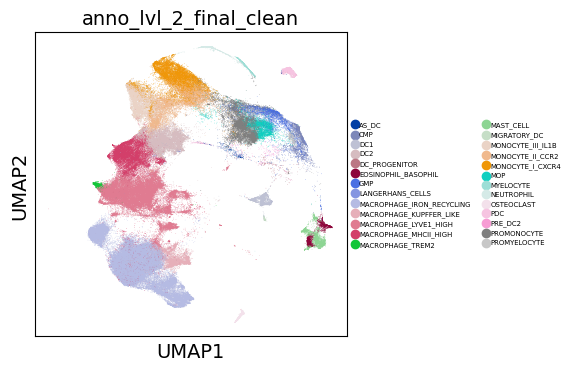

In [11]:
sc.pl.umap(mye, color="anno_lvl_2_final_clean",legend_fontsize= 5  )

In [12]:
sc.pp.normalize_per_cell(mye, counts_per_cell_after=10e4)
sc.pp.log1p(mye)

In [13]:
#pip install --user scikit-misc
#sc.pp.highly_variable_genes(adata, n_top_genes=2000, flavor= "seurat_v3" )min_mean :
sc.settings.verbosity = 4
sc.pp.highly_variable_genes(mye, min_mean=0.3, max_mean=5)

extracting highly variable genes
    Gene indices [1709, 25342] fell into a single bin: their normalized dispersion was set to 1.
    Decreasing `n_bins` will likely avoid this effect.
    finished (0:00:27)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


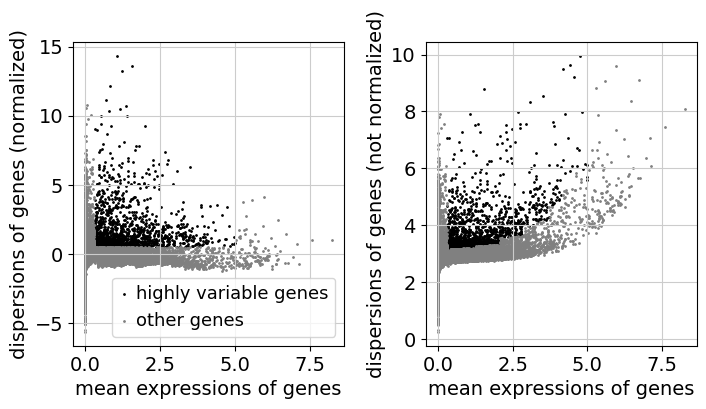

In [14]:
sc.pl.highly_variable_genes(mye)

normalizing counts per cell
    finished (0:00:01)


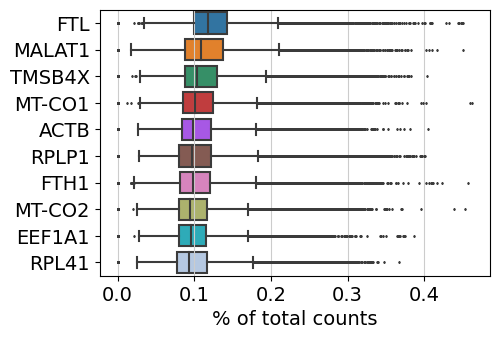

In [15]:
sc.pl.highest_expr_genes(mye, n_top=10, show=True)

### Perform comparison between t-test and wilcox data

ranking genes
    consider 'anno_lvl_2_final_clean' groups:
    with sizes: [  266  2555  3138 11491   200  2334  3995    66 48640  5214 35001 14872
   888  3897   421  8675 10660 11891  3753  1019  1075  1199  2473   215
  9866  1466]
    finished: added to `.uns['t-test']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:59)


/home/irepan/anaconda3/envs/pyscenic/lib/python3.7/site-packages/scanpy/tools/_rank_genes_groups.py:394: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
/home/irepan/anaconda3/envs/pyscenic/lib/python3.7/site-packages/scanpy/tools/_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'scores'] = scores[global_indices]
/home/irepan/anaconda3/envs/pyscenic/lib/python3.7/site-packages/scanpy/tools/_rank_genes_groups.py:399: Pe

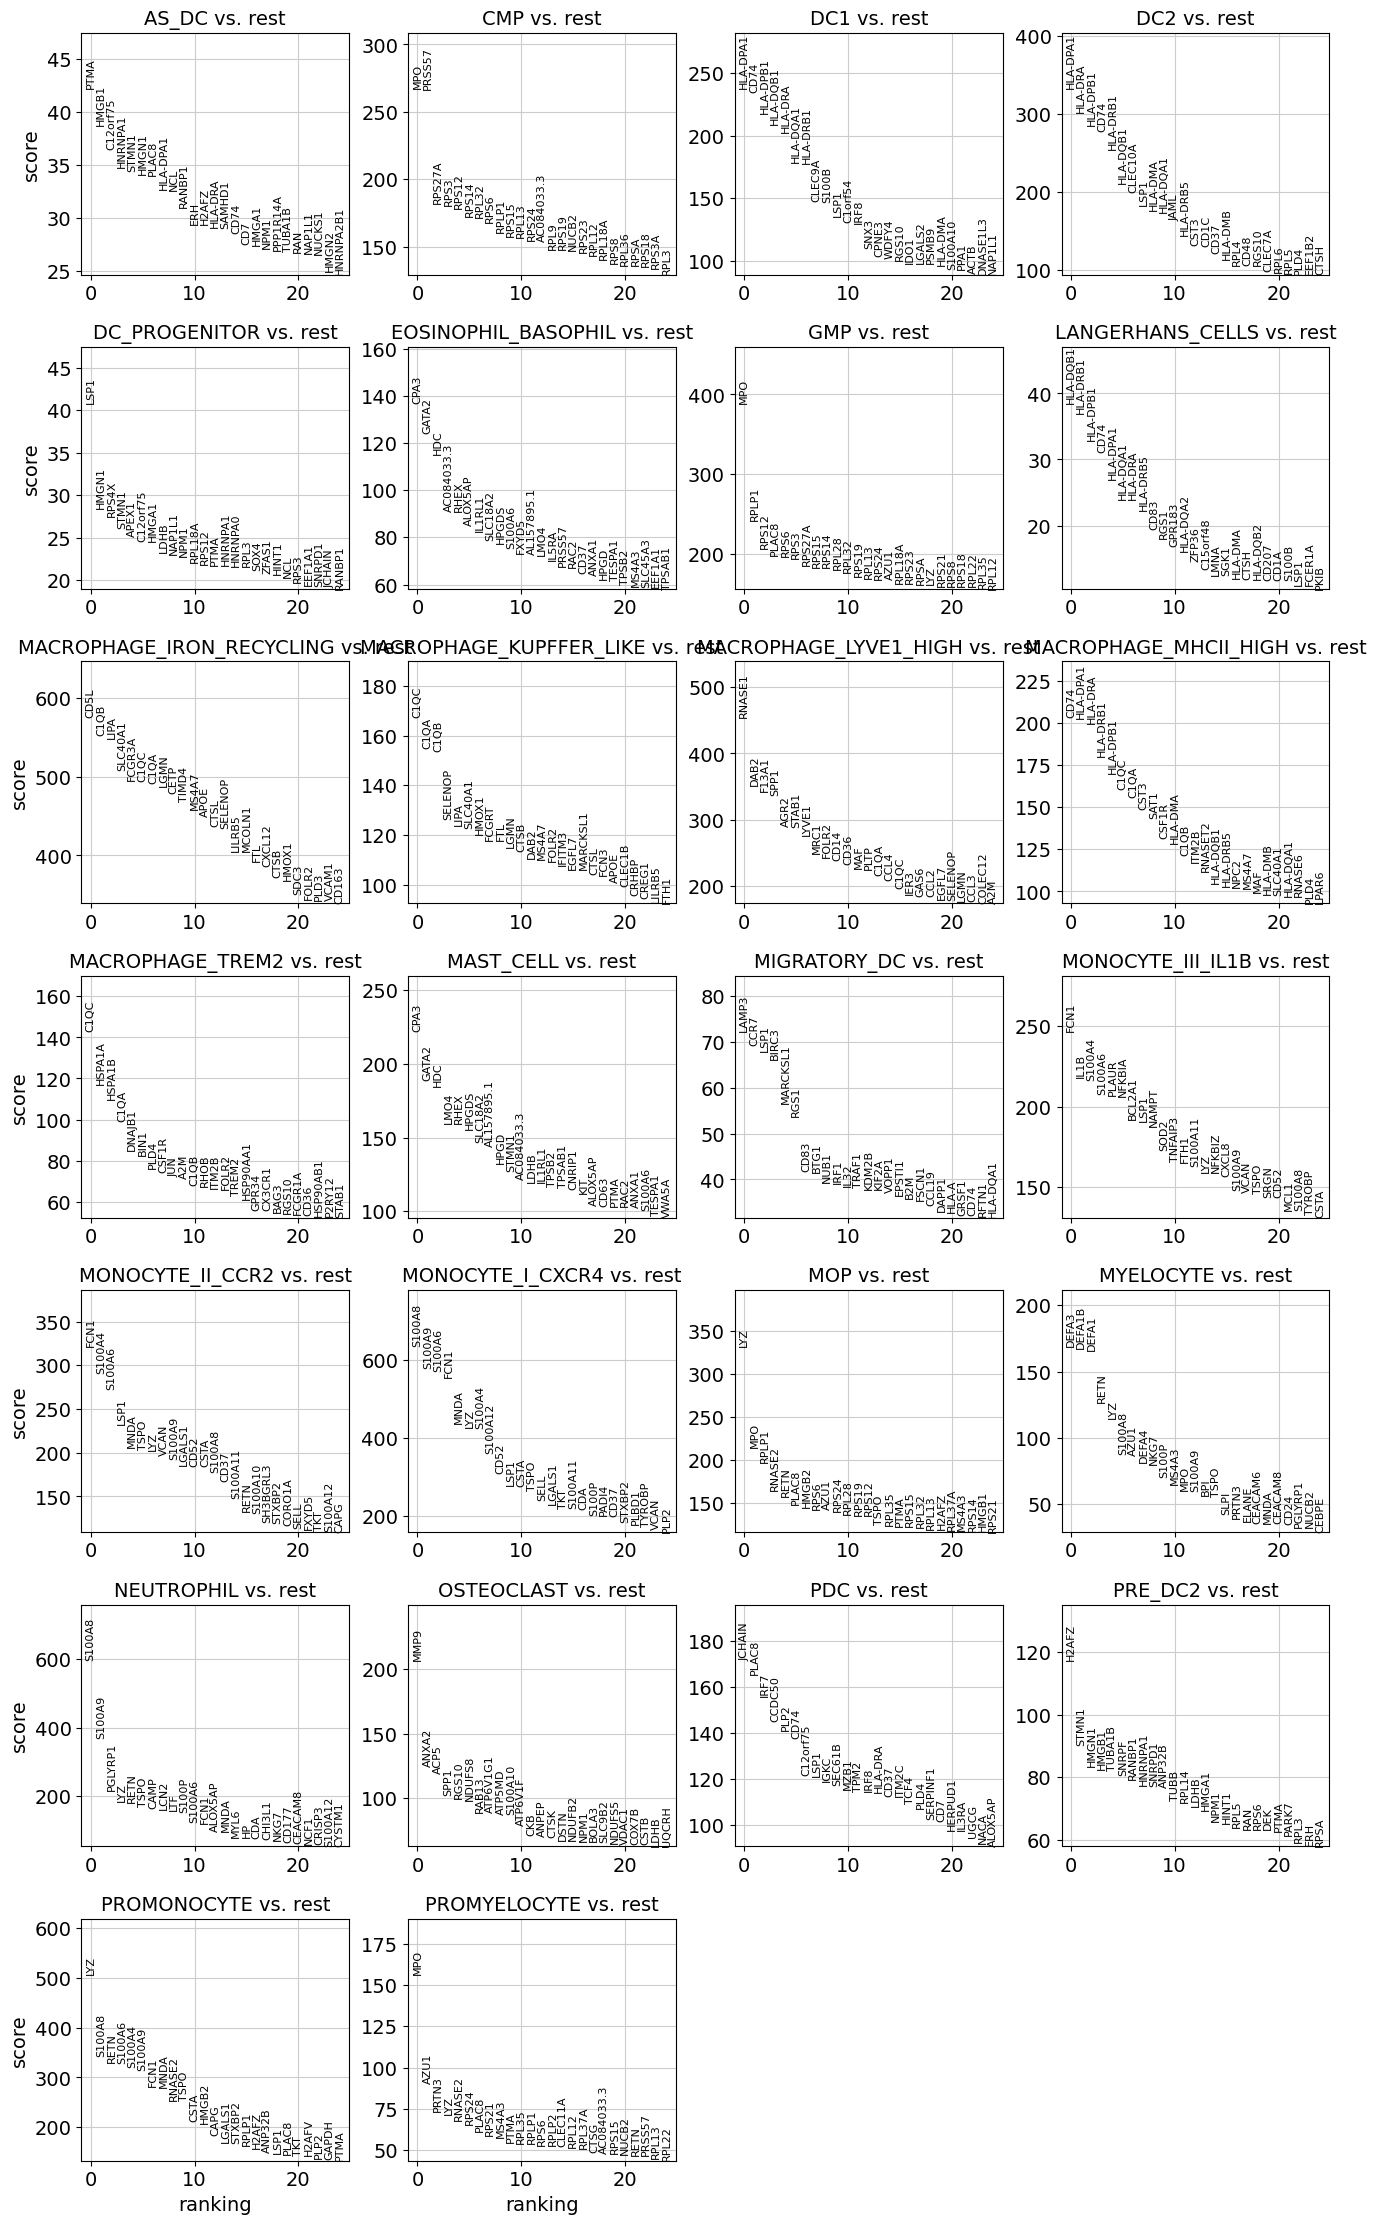

In [17]:
sc.tl.rank_genes_groups(mye, groupby= 'anno_lvl_2_final_clean', method='t-test', key_added= "t-test")
sc.pl.rank_genes_groups(mye,  n_genes=25,  sharey=False, key= "t-test")

ranking genes
    consider 'anno_lvl_2_final_clean' groups:
    with sizes: [  266  2555  3138 11491   200  2334  3995    66 48640  5214 35001 14872
   888  3897   421  8675 10660 11891  3753  1019  1075  1199  2473   215
  9866  1466]
    finished: added to `.uns['wilcoxon']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:09:43)


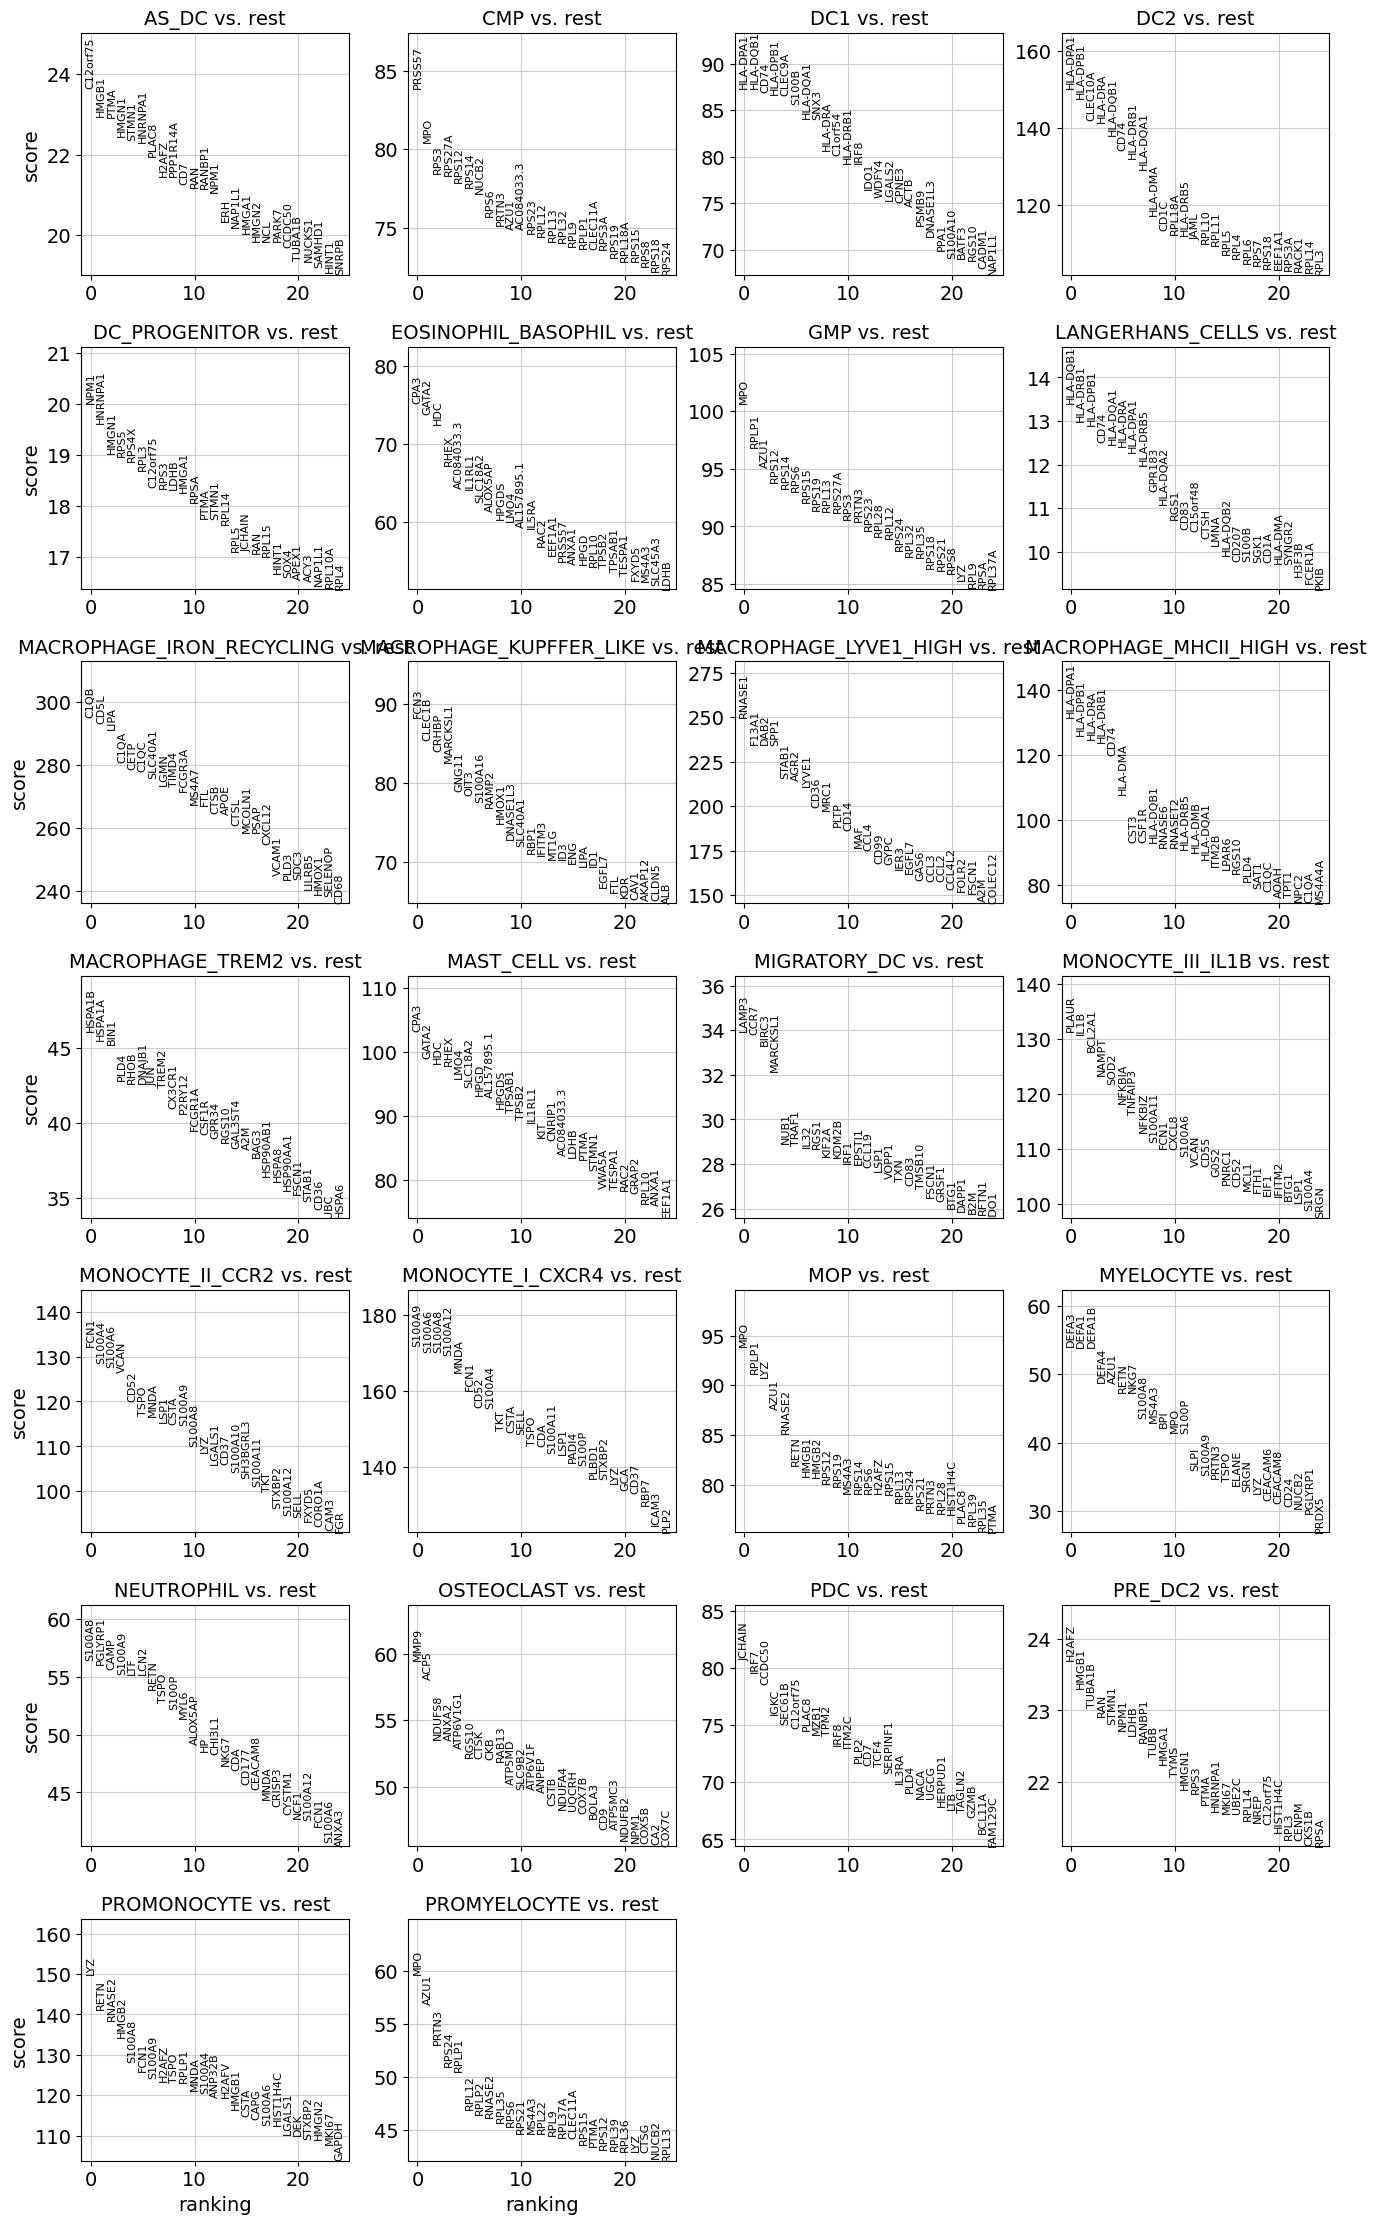

In [18]:
sc.tl.rank_genes_groups(mye, groupby= 'anno_lvl_2_final_clean', method='wilcoxon', key_added= "wilcoxon")
sc.pl.rank_genes_groups(mye,  n_genes=25,  sharey=False, key= "wilcoxon")

In [19]:
mye.write(tmpfile)

## Read preprocessed data

In [4]:
adata = sc.read_h5ad(tmpfile)

In [5]:
for clust in adata.obs.anno_lvl_2_final_clean.cat.categories: 
    f = "./DE_genelists_log2FC/MYELOID_ALL/" + clust + ".csv"
    df = sc.get.rank_genes_groups_df(adata, group=clust,
                                    key='wilcoxon')
    df.to_csv(f, sep=",")

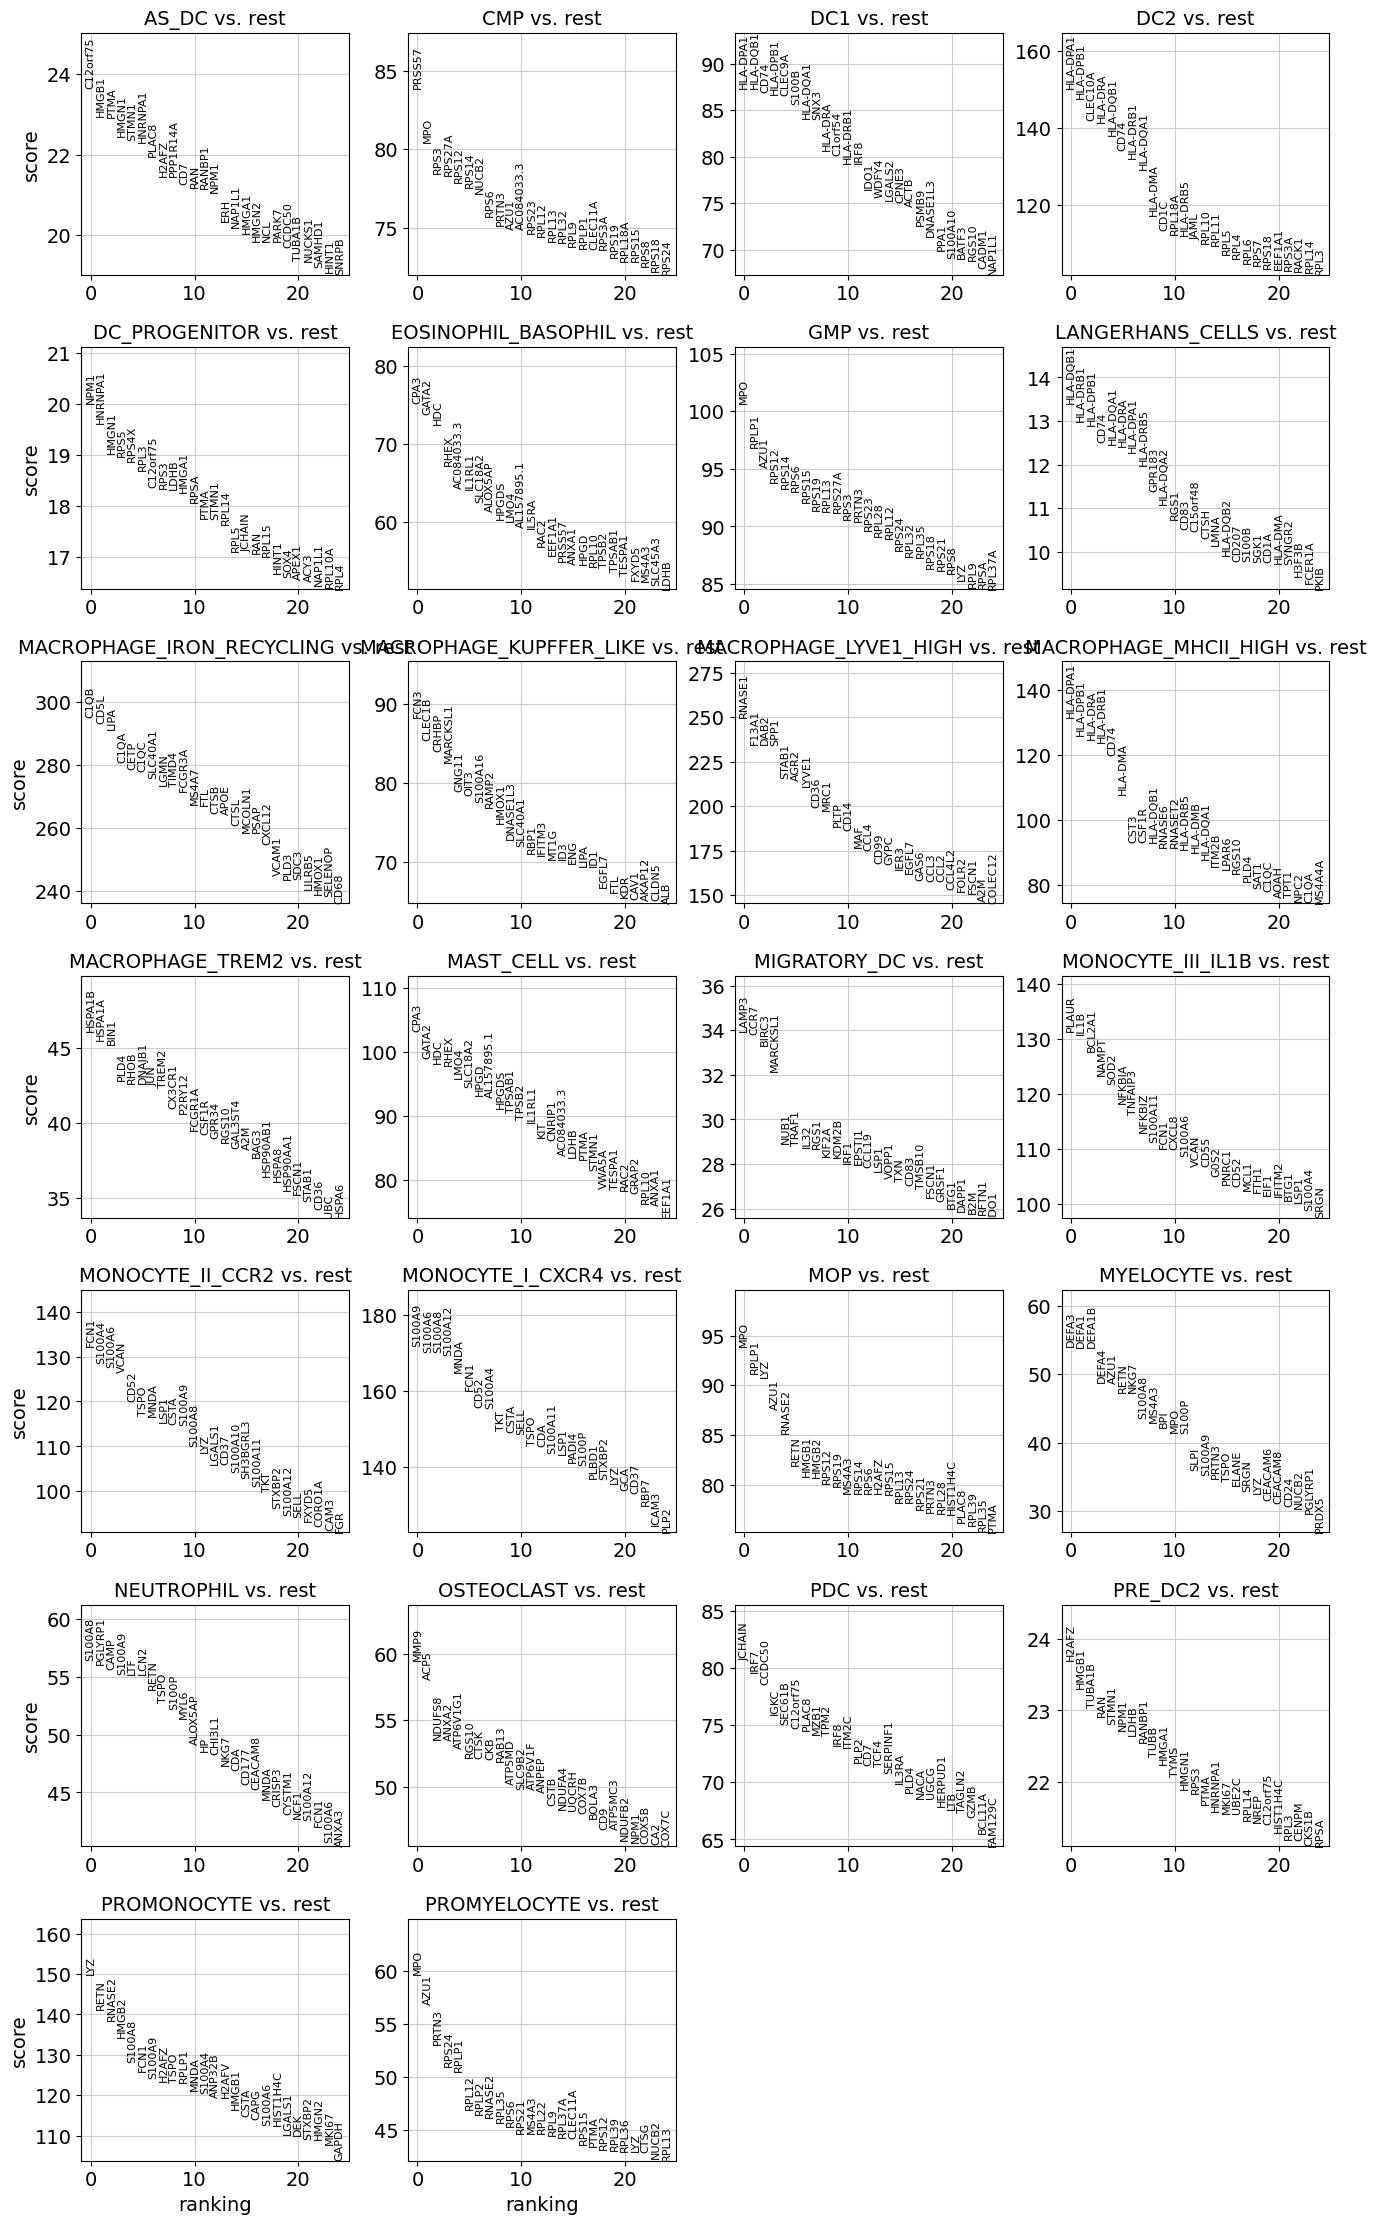

In [5]:
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False, key = "wilcoxon")

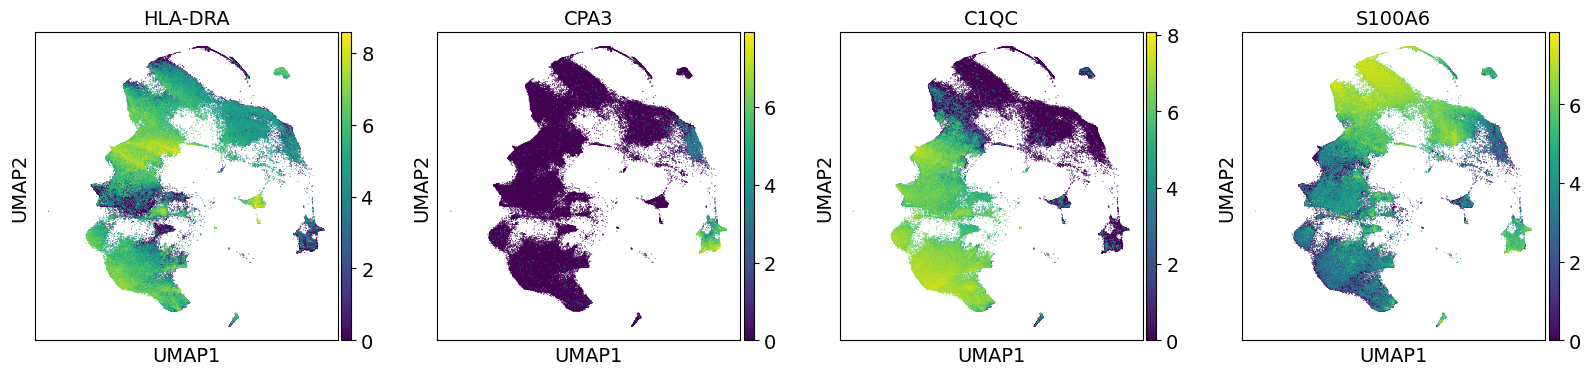

In [6]:
sc.pl.umap(adata, color= ["HLA-DRA", "CPA3","C1QC" ,"S100A6"], size=2 ) # top

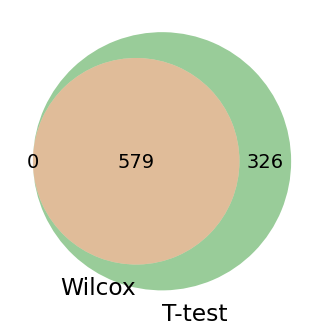

In [7]:
#compare DC2s genes
from matplotlib_venn import venn2

wc = sc.get.rank_genes_groups_df(adata, group='DC2', key='wilcoxon', pval_cutoff=0.0001, log2fc_min=1)
tt = sc.get.rank_genes_groups_df(adata, group='DC2', key='t-test', pval_cutoff=0.0001, log2fc_min=1)

venn2([set(wc['names']),set(tt['names'])], ('Wilcox','T-test') )
plt.show()

## Loop to produce the lists of Myeloid lineages

In [9]:
Subtypes = adata.obs['anno_lvl_2_final_clean'].unique()
Subtypes

['PRE_DC2', 'MONOCYTE_II_CCR2', 'DC1', 'PROMONOCYTE', 'DC2', ..., 'MACROPHAGE_KUPFFER_LIKE', 'MIGRATORY_DC', 'MACROPHAGE_TREM2', 'AS_DC', 'OSTEOCLAST']
Length: 26
Categories (26, object): ['AS_DC', 'CMP', 'DC1', 'DC2', ..., 'PDC', 'PRE_DC2', 'PROMONOCYTE', 'PROMYELOCYTE']

In [10]:
for i in range(0,len(Subtypes)):
    print(i, Subtypes[i])

0 PRE_DC2
1 MONOCYTE_II_CCR2
2 DC1
3 PROMONOCYTE
4 DC2
5 MONOCYTE_III_IL1B
6 MAST_CELL
7 PDC
8 GMP
9 EOSINOPHIL_BASOPHIL
10 MACROPHAGE_MHCII_HIGH
11 PROMYELOCYTE
12 MACROPHAGE_LYVE1_HIGH
13 MOP
14 MYELOCYTE
15 LANGERHANS_CELLS
16 MONOCYTE_I_CXCR4
17 NEUTROPHIL
18 CMP
19 MACROPHAGE_IRON_RECYCLING
20 DC_PROGENITOR
21 MACROPHAGE_KUPFFER_LIKE
22 MIGRATORY_DC
23 MACROPHAGE_TREM2
24 AS_DC
25 OSTEOCLAST


### Marker genes for each Subtype

In [11]:
Markers = [[]]*len(Subtypes)

for i in range(0,len(Subtypes)):
    print(i, Subtypes[i])
    m = sc.get.rank_genes_groups_df(adata, group=Subtypes[i],
                                    key='wilcoxon', pval_cutoff=0.0001,
                                    log2fc_min=1)
    m = m.sort_values("logfoldchanges", ascending=False)
    m.reset_index(drop=True, inplace=True)
    Markers[i] = m

0 PRE_DC2
1 MONOCYTE_II_CCR2
2 DC1
3 PROMONOCYTE
4 DC2
5 MONOCYTE_III_IL1B
6 MAST_CELL
7 PDC
8 GMP
9 EOSINOPHIL_BASOPHIL
10 MACROPHAGE_MHCII_HIGH
11 PROMYELOCYTE
12 MACROPHAGE_LYVE1_HIGH
13 MOP
14 MYELOCYTE
15 LANGERHANS_CELLS
16 MONOCYTE_I_CXCR4
17 NEUTROPHIL
18 CMP
19 MACROPHAGE_IRON_RECYCLING
20 DC_PROGENITOR
21 MACROPHAGE_KUPFFER_LIKE
22 MIGRATORY_DC
23 MACROPHAGE_TREM2
24 AS_DC
25 OSTEOCLAST


### Get names of 300 top markers (if possible) for each Subtype

In [12]:
#pip install upsetplot
from upsetplot import from_contents
from upsetplot import UpSet

In [13]:
Sets = [[]]*len(Subtypes)
CompleteSets = [[]]*len(Subtypes)

for i in range(0,len(Subtypes)):
    CompleteSets[i] = Markers[i]['names']
    n = len(Markers[i])
    #print(i, Subtypes[i], n)
    if n > 300 :
        #print("yes")
        Sets[i] = Markers[i].loc[0:299,'names']
    else :
        #print("no")
        Sets[i] = Markers[i].loc[0:n-1,'names']

In [14]:
Dict_markers =  {}
CompleteDict_markers =  {}

for i in range(0,len(Subtypes)):
    Dict_markers[Subtypes[i]] = Sets[i]
    CompleteDict_markers[Subtypes[i]] = CompleteSets[i]

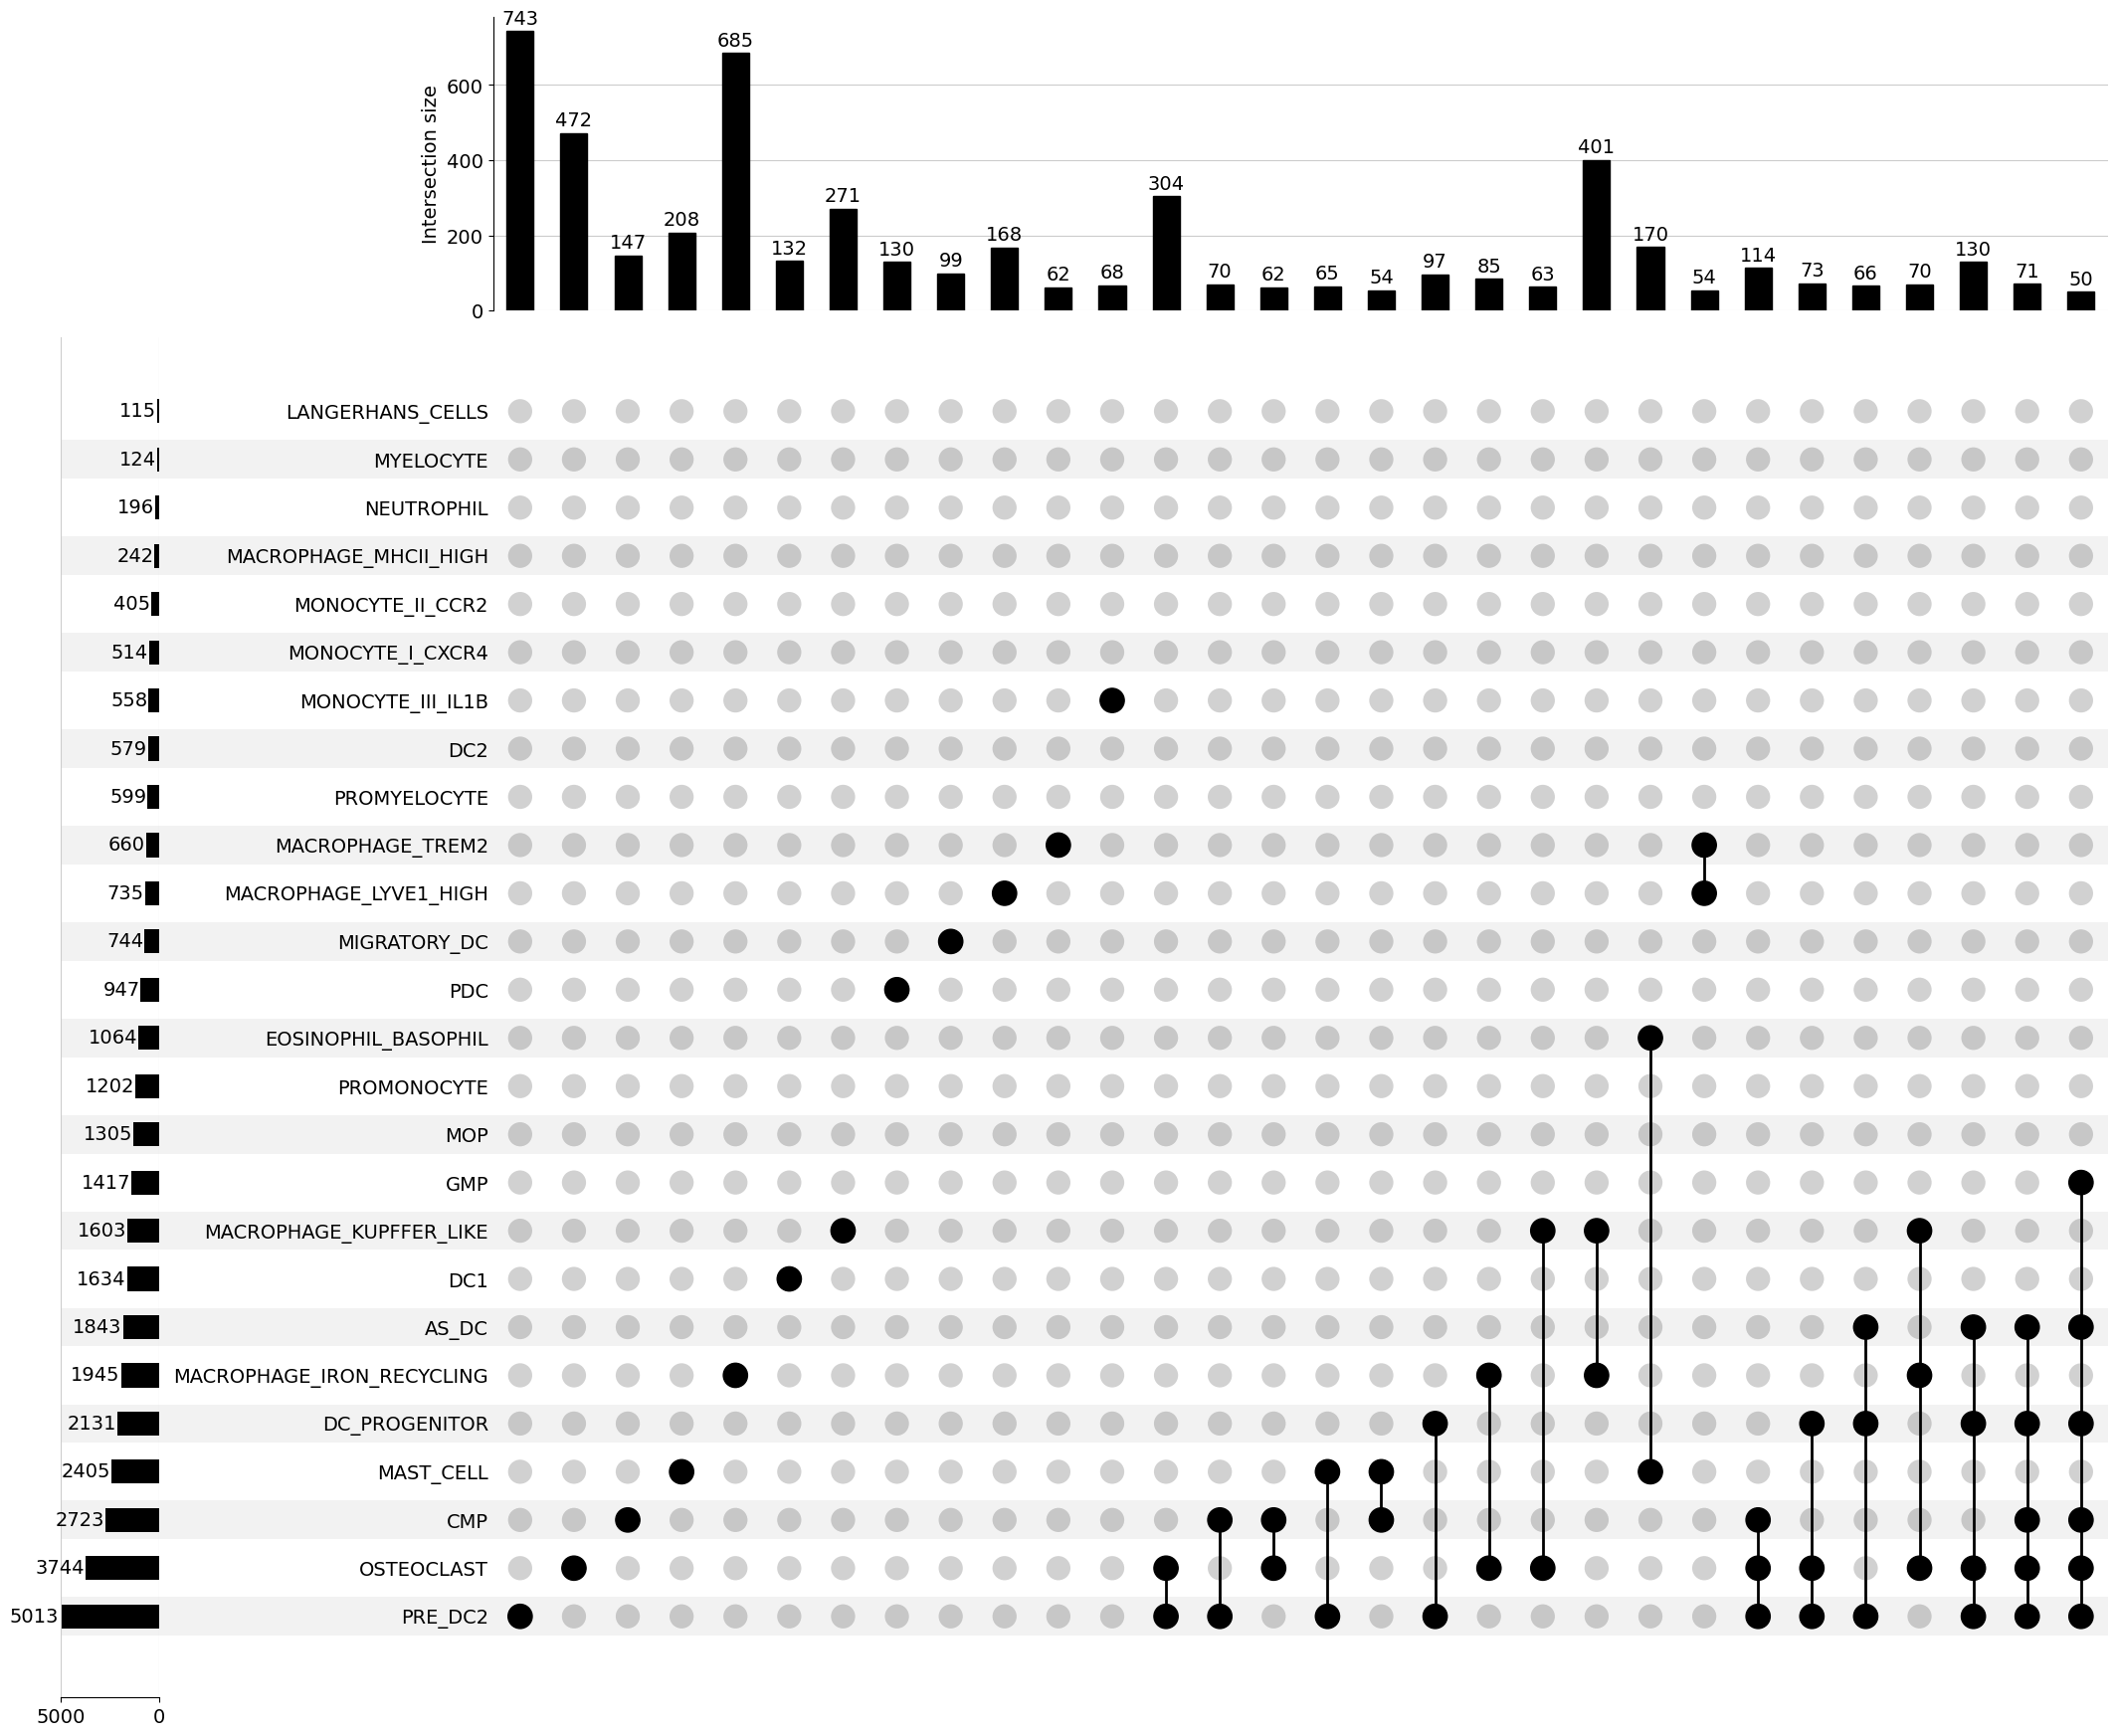

In [15]:
CT_markers = from_contents(CompleteDict_markers)

plt = UpSet(CT_markers, min_subset_size=50, subset_size='count',element_size=50,  show_counts=True).plot()

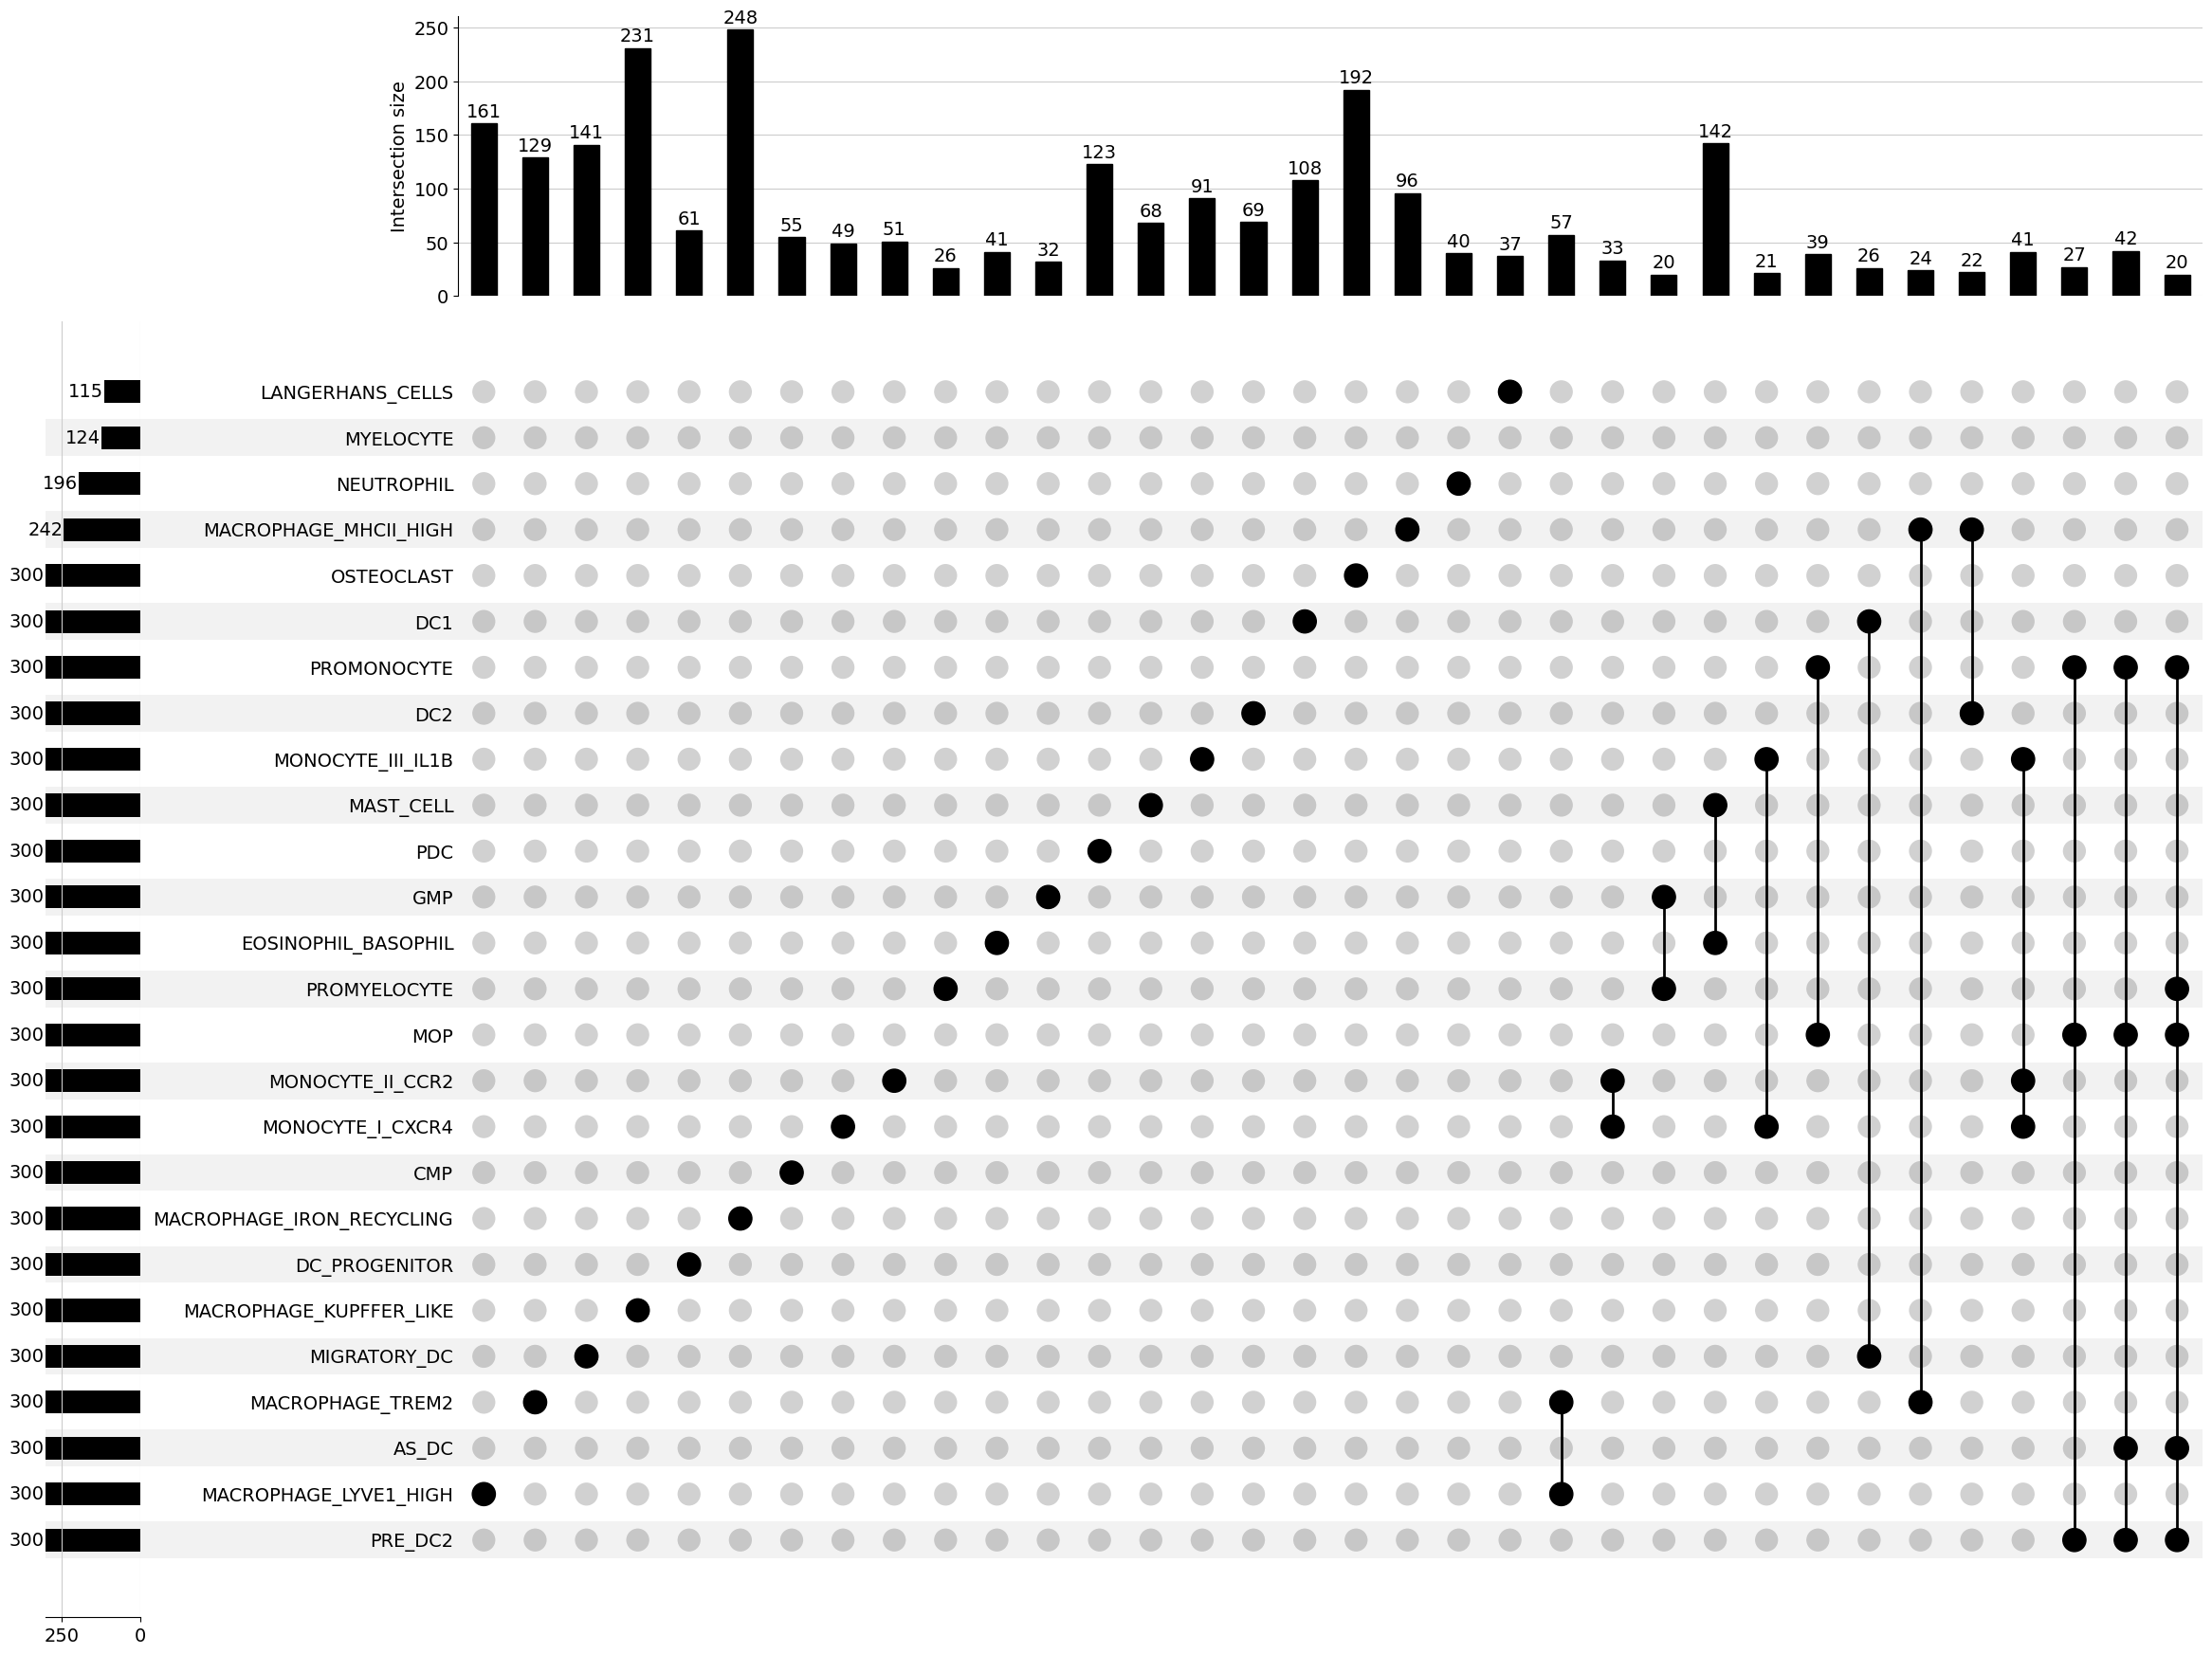

In [16]:
CT_markers = from_contents(Dict_markers)

plt = UpSet(CT_markers, min_subset_size=20, subset_size='count',element_size=50,  show_counts=True).plot()

In [17]:
Dict_markers['DC1'].loc[0:3]

0        XCR1
1    RFPL4AL1
2      CLEC9A
3        IDO1
Name: names, dtype: object

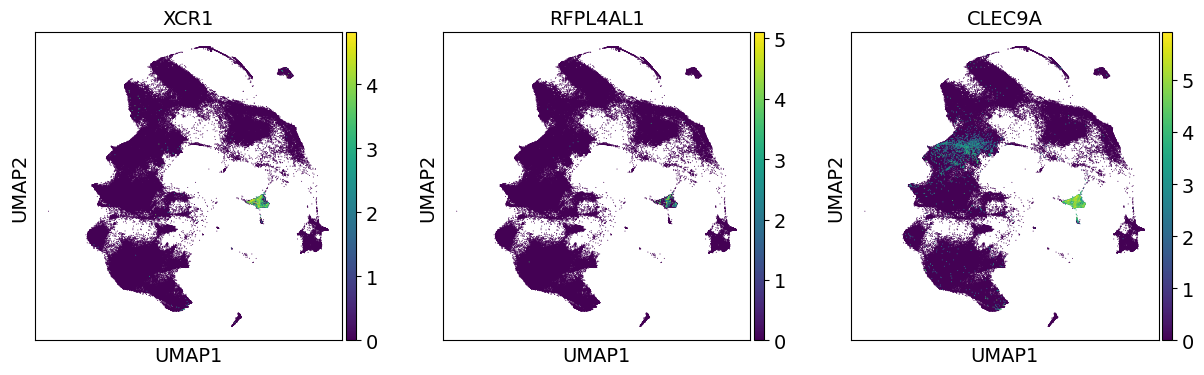

In [18]:
sc.pl.umap(adata, color= ["XCR1", "RFPL4AL1","CLEC9A"], size= 2  ) # top

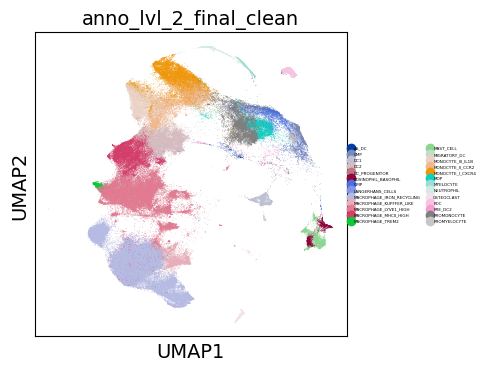

In [19]:
sc.pl.umap(adata, color=["anno_lvl_2_final_clean"], 
           save= "Myeloid_lineages_ALL.png", legend_fontsize= 3 )

In [20]:
# Calling DataFrame constructor after zipping
# both lists, with columns specified
df = pd.DataFrame(list(zip(Sets[0], Sets[1],  Sets[2], Sets[3], Sets[4], Sets[5],  Sets[6],
                           Sets[7], Sets[8],  Sets[9], #Sets[10],
                           Sets[11],Sets[12],Sets[13], #Sets[14],Sets[15],
                           Sets[16],                   #Sets[17],
                           Sets[18],Sets[19],Sets[20],Sets[21], Sets[22], Sets[23],Sets[24],
                           Sets[25] )),
               columns =[Subtypes[0], Subtypes[1], Subtypes[2], Subtypes[3], Subtypes[4],
                         Subtypes[5], Subtypes[6], Subtypes[7], Subtypes[8], Subtypes[9],# Subtypes[10],
                         Subtypes[11],Subtypes[12],Subtypes[13],                        #Subtypes[14], Subtypes[15],
                         Subtypes[16],                                                  #Subtypes[17],
                         Subtypes[18],Subtypes[19], Subtypes[20], Subtypes[21],
                         Subtypes[22],Subtypes[23], Subtypes[24], Subtypes[25]])

MACROPHAGE_MHCII_HIGH_df = pd.DataFrame(list(zip(Sets[10])),columns =[Subtypes[10]])
MYELOCYTE                = pd.DataFrame(list(zip(Sets[14])),columns =[Subtypes[14]])
LANGERHANS_CELLS         = pd.DataFrame(list(zip(Sets[15])),columns =[Subtypes[15]])
NEUTROPHIL               = pd.DataFrame(list(zip(Sets[17])),columns =[Subtypes[17]])


df

,PRE_DC2,MONOCYTE_II_CCR2,DC1,PROMONOCYTE,DC2,MONOCYTE_III_IL1B,MAST_CELL,PDC,GMP,EOSINOPHIL_BASOPHIL,...,MOP,MONOCYTE_I_CXCR4,CMP,MACROPHAGE_IRON_RECYCLING,DC_PROGENITOR,MACROPHAGE_KUPFFER_LIKE,MIGRATORY_DC,MACROPHAGE_TREM2,AS_DC,OSTEOCLAST
0,KCNE5,S100A8,XCR1,S100A8,CLEC10A,ACOD1,TPSAB1,JCHAIN,MPO,CLC,...,MPO,S100A8,PRTN3,CD5L,JCHAIN,STAB2,NCCRP1,GAL3ST4,PPM1J,AL136298.1
1,UBE2C,FCN1,RFPL4AL1,LYZ,CD207,IL1B,TPSB2,AC104024.1,PRTN3,CPA3,...,PRTN3,S100A12,MPO,CETP,SPINK2,OIT3,CCL19,P2RY12,SCT,AP000904.1
2,MPO,VCAN,CLEC9A,RNASE2,CD1C,G0S2,CPA3,GZMB,AZU1,GATA2,...,AZU1,S100A9,AZU1,VCAM1,FAM129C,KDR,FOXD4L3,CX3CR1,PPP1R14A,AC092484.1
3,TYMS,S100A9,IDO1,S100A9,HLA-DPA1,BCL2A1,HDC,AC097375.1,CTSG,HDC,...,LYZ,FCN1,PRSS57,AC104389.5,VPREB1,FCN3,LAMP3,TREM2,SPIB,MMP9
4,HTR3A,S100A6,PPY,FCN1,HLA-DPB1,AQP9,GATA2,IGLJ2,LYZ,IL5RA,...,MS4A3,ORM1,C1QTNF4,C1QB,CD3E,FGF23,CCR7,OLFML3,C12orf75,CTSK
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,TOP1MT,SVIL,ASAP1,PNOC,SLC9A7,RABGEF1,GAPT,SLC7A6,UCK2,MAP1A,...,HIST1H2BF,FXYD5,CENPU,TPRG1,SLC12A2,HMGCS2,PTK2B,RAD50,NUP37,ATP6V1E1
296,SYNGR1,DNAJA4,TSTD1,S1PR4,CAMK1,SRSF5,TNIK,TLR7,BRIP1,TRIB2,...,TRIP13,GPSM3,SERPINE2,PTPRM,HNRNPA0,LRRC32,HLA-DQA2,CCDC50,SSX2IP,PARVA
297,CMSS1,NBPF19,LONRF1,CDC6,NME2,ARHGAP24,GALNT14,SEPT6,MMS22L,PXDN,...,NRGN,TNFSF14,NPM3,YPEL4,OFD1,ALDOB,CHD3,KDELC2,HJURP,IL7R
298,SUPT16H,SH3BGRL3,SPINT1,IGFBP7,HMGN4,CLEC4A,NLRC3,PAIP2B,GNL3,C12orf57,...,TACC3,MTMR3,PPA1,MMP15,PTTG1,KIAA1671,VDAC2,P2RY6,EEF1E1,PLK1


In [21]:
# pip install rpy2
# enables the %%R magic, not necessary if you've already done this
%load_ext rpy2.ipython

In [22]:
%%R -i df -w 5 -h 5 --units in -r 200
# import df from global environment
# make default figure size 5 by 5 inches with 200 dpi resolution
library("EnsDb.Hsapiens.v86")

head(df)

R[write to console]: Loading required package: ensembldb

R[write to console]: Loading required package: BiocGenerics

R[write to console]: 
Attaching package: ‘BiocGenerics’


R[write to console]: The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


R[write to console]: The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which.max, which.min


R[write to console]: Loading required package: GenomicRanges

R[write to console]: Loading required package: stats4

R[write to console]: Loading required package: S4Vectors

R[write to console]: 
Attaching package: ‘S4Vectors’


R[write to cons

   PRE_DC2 MONOCYTE_II_CCR2      DC1 PROMONOCYTE      DC2 MONOCYTE_III_IL1B
0    KCNE5           S100A8     XCR1      S100A8  CLEC10A             ACOD1
1    UBE2C             FCN1 RFPL4AL1         LYZ    CD207              IL1B
2      MPO             VCAN   CLEC9A      RNASE2     CD1C              G0S2
3     TYMS           S100A9     IDO1      S100A9 HLA-DPA1            BCL2A1
4    HTR3A           S100A6      PPY        FCN1 HLA-DPB1              AQP9
5 HIST1H4C              LYZ   RFPL4A       MKI67   FCER1A            S100A8
   MAST_CELL        PDC    GMP EOSINOPHIL_BASOPHIL PROMYELOCYTE
0     TPSAB1     JCHAIN    MPO                 CLC          MPO
1      TPSB2 AC104024.1  PRTN3                CPA3        PRTN3
2       CPA3       GZMB   AZU1               GATA2         AZU1
3        HDC AC097375.1   CTSG                 HDC         CTSG
4      GATA2      IGLJ2    LYZ               IL5RA       PRSS57
5 AL157895.1      NLRP7 PRSS57              IL1RL1        ELANE
  MACROPHAGE_LYVE1_H

In [23]:
%%R

library(stringr)
dim(df)
genelists <- colnames(df)
path <- "~/Desktop/Github/Immune_Adaptation_Atlas/ENS_genelists_wilcox/Myeloid_ALL/"

for (i in genelists)
    {
    goi <- df[,i]
    #print(i)
    f <- str_remove_all(i, "[()]")
    print(f)
    ens_df <- ensembldb::select(EnsDb.Hsapiens.v86, keys= goi, 
                              keytype = "SYMBOL", 
                              columns = c("SYMBOL","GENEID"))
   
    ens_df <- ens_df$GENEID[grepl(pattern = "^ENS", x = ens_df$GENEID)]
    #print(head(ens_df)) 

    write(x = ens_df, file = paste0(path, f ,"_ENSEMBL.txt"),ncolumns = 1)

    }

[1] "PRE_DC2"
[1] "MONOCYTE_II_CCR2"
[1] "DC1"
[1] "PROMONOCYTE"
[1] "DC2"
[1] "MONOCYTE_III_IL1B"
[1] "MAST_CELL"
[1] "PDC"
[1] "GMP"
[1] "EOSINOPHIL_BASOPHIL"
[1] "PROMYELOCYTE"
[1] "MACROPHAGE_LYVE1_HIGH"
[1] "MOP"
[1] "MONOCYTE_I_CXCR4"
[1] "CMP"
[1] "MACROPHAGE_IRON_RECYCLING"
[1] "DC_PROGENITOR"
[1] "MACROPHAGE_KUPFFER_LIKE"
[1] "MIGRATORY_DC"
[1] "MACROPHAGE_TREM2"
[1] "AS_DC"
[1] "OSTEOCLAST"


In [24]:
%%R -i MACROPHAGE_MHCII_HIGH_df
# import df from global environment
head(MACROPHAGE_MHCII_HIGH_df)

goi <- MACROPHAGE_MHCII_HIGH_df[,1]
f <- str_remove_all(colnames(MACROPHAGE_MHCII_HIGH_df)[1], "[()]") 
print(f)
ens_df <- ensembldb::select(EnsDb.Hsapiens.v86, keys= goi, 
                            keytype = "SYMBOL", 
                            columns = c("SYMBOL","GENEID"))
   
ens_df <- ens_df$GENEID[grepl(pattern = "^ENS", x = ens_df$GENEID)]
print(head(ens_df)) 

write(x = ens_df, file = paste0(path, f,"_ENSEMBL.txt"),ncolumns = 1)

[1] "MACROPHAGE_MHCII_HIGH"
[1] "ENSG00000168384" "ENSG00000206291" "ENSG00000224103" "ENSG00000228163"
[5] "ENSG00000229685" "ENSG00000231389"


In [25]:
%%R -i MYELOCYTE
# import df from global environment
head(MYELOCYTE)

goi <- MYELOCYTE[,1]
f <- str_remove_all(colnames(MYELOCYTE)[1], "[()]") 
print(f)
ens_df <- ensembldb::select(EnsDb.Hsapiens.v86, keys= goi, 
                            keytype = "SYMBOL", 
                            columns = c("SYMBOL","GENEID"))
   
ens_df <- ens_df$GENEID[grepl(pattern = "^ENS", x = ens_df$GENEID)]
print(head(ens_df)) 

write(x = ens_df, file = paste0(path, f,"_ENSEMBL.txt"),ncolumns = 1)

[1] "MYELOCYTE"
[1] "ENSG00000240247" "ENSG00000206047" "ENSG00000239839" "ENSG00000164821"
[5] "ENSG00000086548" "ENSG00000172232"


In [26]:
%%R -i LANGERHANS_CELLS
# import df from global environment
head(LANGERHANS_CELLS)

goi <- LANGERHANS_CELLS[,1]
f <- str_remove_all(colnames(LANGERHANS_CELLS)[1], "[()]") 
print(f)
ens_df <- ensembldb::select(EnsDb.Hsapiens.v86, keys= goi, 
                            keytype = "SYMBOL", 
                            columns = c("SYMBOL","GENEID"))
   
ens_df <- ens_df$GENEID[grepl(pattern = "^ENS", x = ens_df$GENEID)]
print(head(ens_df)) 

write(x = ens_df, file = paste0(path, f,"_ENSEMBL.txt"),ncolumns = 1)

[1] "LANGERHANS_CELLS"
[1] "ENSG00000116031" "ENSG00000196610" "ENSG00000224305" "ENSG00000226165"
[5] "ENSG00000228254" "ENSG00000228813"


In [27]:
%%R -i NEUTROPHIL
# import df from global environment
head(NEUTROPHIL)

goi <- NEUTROPHIL[,1]
f <- str_remove_all(colnames(NEUTROPHIL)[1], "[()]") 
print(f)
ens_df <- ensembldb::select(EnsDb.Hsapiens.v86, keys= goi, 
                            keytype = "SYMBOL", 
                            columns = c("SYMBOL","GENEID"))
   
ens_df <- ens_df$GENEID[grepl(pattern = "^ENS", x = ens_df$GENEID)]
print(head(ens_df)) 

write(x = ens_df, file = paste0(path, f,"_ENSEMBL.txt"),ncolumns = 1)

[1] "NEUTROPHIL"
[1] "ENSG00000148346" "ENSG00000164047" "ENSG00000012223" "ENSG00000204936"
[5] "ENSG00000143546" "ENSG00000008438"


## Export full list of marker genes

In [28]:
full_csv_path = '/home/irepan/Desktop/Github/Immune_Adaptation_Atlas/ENS_FULL_genelists_wilcox/Myeloid_ALL/full.csv'

(pd.DataFrame.from_dict(data=CompleteDict_markers, orient='index')
   .to_csv(full_csv_path, header=False))

In [29]:
%%R -i full_csv_path
library("EnsDb.Hsapiens.v86")
library(stringr)

path <- "~/Desktop/Github/Immune_Adaptation_Atlas/ENS_FULL_genelists_wilcox/Myeloid_ALL/"

mycsv <- read.csv(full_csv_path, row.names = 1,header = F, na.strings = "")

for (i in 1:nrow(mycsv))
{
    genelist <- row.names(mycsv)[i]
    n <- sum(!is.na(mycsv[i,]))
    #print(paste0(n," genes"))
    
    goi <- as.character(mycsv[i,1:n])
    print(goi[1:5])

    f <- str_remove_all(genelist, "[()]")
    print(f)
    ens_df <- ensembldb::select(EnsDb.Hsapiens.v86, keys= goi, 
                              keytype = "SYMBOL", 
                              columns = c("SYMBOL","GENEID"))
   
    ens_df <- ens_df$GENEID[grepl(pattern = "^ENS", x = ens_df$GENEID)]
    #print(head(ens_df)) 

    write(x = ens_df, file = paste0(path, f ,"_FULL_ENSEMBL.txt"),ncolumns = 1)

}


[1] "KCNE5" "UBE2C" "MPO"   "TYMS"  "HTR3A"
[1] "PRE_DC2"
[1] "S100A8" "FCN1"   "VCAN"   "S100A9" "S100A6"
[1] "MONOCYTE_II_CCR2"
[1] "XCR1"     "RFPL4AL1" "CLEC9A"   "IDO1"     "PPY"     
[1] "DC1"
[1] "S100A8" "LYZ"    "RNASE2" "S100A9" "FCN1"  
[1] "PROMONOCYTE"
[1] "CLEC10A"  "CD207"    "CD1C"     "HLA-DPA1" "HLA-DPB1"
[1] "DC2"
[1] "ACOD1"  "IL1B"   "G0S2"   "BCL2A1" "AQP9"  
[1] "MONOCYTE_III_IL1B"
[1] "TPSAB1" "TPSB2"  "CPA3"   "HDC"    "GATA2" 
[1] "MAST_CELL"
[1] "JCHAIN"     "AC104024.1" "GZMB"       "AC097375.1" "IGLJ2"     
[1] "PDC"
[1] "MPO"   "PRTN3" "AZU1"  "CTSG"  "LYZ"  
[1] "GMP"
[1] "CLC"   "CPA3"  "GATA2" "HDC"   "IL5RA"
[1] "EOSINOPHIL_BASOPHIL"
[1] "HLA-DPA1" "HLA-DPB1" "ADAMDEC1" "CLDN4"    "HLA-DRA" 
[1] "MACROPHAGE_MHCII_HIGH"
[1] "MPO"    "PRTN3"  "AZU1"   "CTSG"   "PRSS57"
[1] "PROMYELOCYTE"
[1] "SPP1"    "RNASE1"  "F13A1"   "GAPLINC" "GPR12"  
[1] "MACROPHAGE_LYVE1_HIGH"
[1] "MPO"   "PRTN3" "AZU1"  "LYZ"   "MS4A3"
[1] "MOP"
[1] "DEFA1B"  "DEFA1"   "DEFA3"  